# Tutorial 01 — Create Synthetic Disk

We will create a disk parameter dictionary:

- Chemistry block (`chemistry`)
- Disk block (`disk`)

Save the parameters to `tutorial01_params.yaml` (which we will later use in `tutorial02`!) <br>
Plot the disk structure.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from radjax import utils, visualization
from radjax import chemistry as chem

## Define Disk parameters and save to yaml
We use a simple surface density profile with a break at `r_break`, plus a power-law temperature. <br> Matches schema: top-level `name`, `chemistry`, `disk`.


In [2]:
params_path = "./tutorial01_params.yaml"

params = {
    "chemistry": {
        "molecule": "CO",
        "line_index": 3,
        "line_name": "CO(3-2)",
        "co_abundance": 1.0e-4,
        "freezeout": 20.0,          # [K]
        "N_dissoc": 1.256e21,       # [cm^-2]
        "N_desorp": None,           # [cm^-2], optional
        "molecular_table": "data/molecular_tables/molecule_12c16o.inp",  # relative path to radjax package
    },
    "disk": {
        # Thermal structure
        "T_mid1": 20,             # [K]
        "T_atm1": 100.0,          # [K]
        "q": -0.5,
        "q_in": -0.5,
        "r_break": -1,            # Negative R_break means no break in the power law
        "log_r_c": 2.3,
        "gamma": 1.0,

        # Mass content
        "M_star": 1.2,              # [M_sun]
        "M_gas": 0.01,              # [M_sun]

        # Geometry / scaling
        "r_in": 11.0,               # [AU]
        "r_scale": 150.0,           # [AU]
        "z_q0": 70.0,               # [AU]
        "delta": 1.0,

        # Kinematics
        "v_turb": 0.1,             # dimensionless

        # Resolution / grid
        "resolution": 500,
        "z_min": 0.0,               # [AU]
        "z_max": 200.0,             # [AU]
        "r_min": 11.0,              # [AU]
        "r_max": 800.0,             # [AU]
    },
}

utils.dump_yaml(params, params_path)

✔️ Saved YAML → ./tutorial01_params.yaml


## Load YAML into radjax containers
We now parse the YAML into radjax dataclasses (flax based) and prepare an axissymetric disk structure

We begin by loading the parametric disk and chemistry configuration from the YAML file.  

- `DiskParams` contains the structural and kinematic setup of the disk.  
- `ChemistryParams` specifies the CO line selection and abundance thresholds.  
- `MolecularData` bundles the energy levels, radiative transitions, and Einstein coefficients 
  for the chosen transition (resolved automatically from the packaged molecular tables).  

Once loaded, we can print each set of parameters for a quick summary.

In [3]:
from radjax.models import broken_power_law as disk_model

disk_params = disk_model.disk_from_yaml(params_path)
chem_params = chem.chemistry_from_yaml_path(params_path)
mol = chem.load_molecular_tables(chem_params)

disk_model.print_params(disk_params)
chem.print_params(chem_params)

Disk parameters (parametric broken power law model):
  Midplane T_norm (K):          20.00
  Atmosphere T_norm (K):       100.00
  q (outer exponent):          -0.500
  q_in (inner exponent):       -0.500
  r_break (AU):                 -1.00
  log(r_c [AU]):                 2.30
  gamma (Σ slope):              1.000

  Stellar mass (M_sun):         1.200
  Gas mass (M_sun):             0.010

  r_in (AU):                    11.00
  r_scale (AU):                150.00
  z_q0 (AU):                    70.00
  delta (blend exp):            1.000

  Turbulence parameter:         0.100

  Resolution (z/r):               500
  z range (AU):                  0.00 →   200.00
  r range (AU):                 11.00 →   800.00
Chemistry parameters (line selection & thresholds):
  Molecule:                   CO
  Line index (J upper):       3
  Line name:                  CO(3-2)

  CO abundance fraction:      1.000e-04
  Freezeout threshold (K):    20.00
  Dissoc. threshold (cm^-2):  1.256e+21
  D

## Build the CO disk model

Using the parameters above, we now construct the disk fields:

- `temperature(z,r)` in Kelvin  
- `v_phi(z,r)` (azimuthal velocity, including pressure support if enabled)  
- `co_nd(z,r)` the CO number density field  
- `base_disk` container with grids and baseline H₂ fields

In [4]:
temperature, v_phi, co_nd, base_disk = disk_model.co_disk_from_params(
    disk_params, chem_params
)

print("Disk fields summary (azimuthal/mirror symmetric fields):")
print(f"  Temperature:        {temperature.shape}, dtype={temperature.dtype}")
print(f"  CO Number Density:  {co_nd.shape}, dtype={co_nd.dtype}")
print(f"  Azimuthal Velocity: {v_phi.shape}, dtype={v_phi.dtype}")

Disk fields summary (azimuthal/mirror symmetric fields):
  Temperature:        (500, 500), dtype=float64
  CO Number Density:  (500, 500), dtype=float64
  Azimuthal Velocity: (500, 500), dtype=float64


## Visualize the radial–vertical structure

We can now plot a slice of the disk showing:

- H₂ number density  
- Temperature  
- CO abundance  

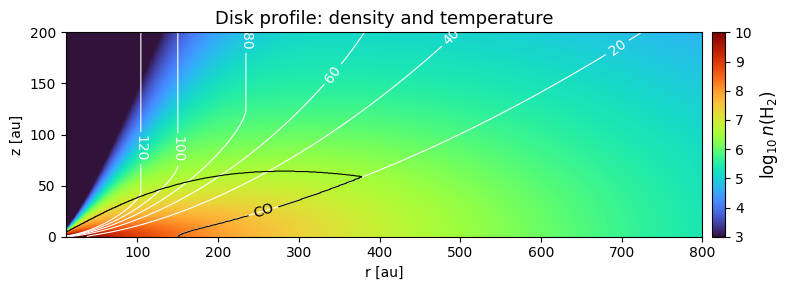

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,3))
visualization.plot_disk_profile_rz(
    ax, base_disk.r, base_disk.z, base_disk.h2_nd, temperature, co_nd
)
plt.tight_layout()